In [ ]:
import psutil
import time
import os
import accelerate
from accelerate import Accelerator
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.cross_encoder import CrossEncoder
from transformers import StoppingCriteria
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datasets import load_metric
from scipy import stats
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
bert_score = load_metric('bertscore', trust_remote_code=True)
rouge = load_metric('rouge', trust_remote_code=True)


In [ ]:
# All models list
model_name = ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
              "microsoft/phi-2", "microsoft/phi-1_5", "microsoft/phi-1",
              "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",]

model_with_3_billon = ["apple/OpenELM-3B","microsoft/phi-2","google/gemma-2b" ]

In [ ]:

# new_dataset = pd.read_csv("new_file_10.csv")
new_dataset = pd.read_csv("result_file.csv")
# model_name = "apple/OpenELM-450M"
# llm_output =  model_name + "_reponse"
new_dataset['output'] = new_dataset['output'].astype(str)
new_dataset = new_dataset.astype(str)
new_dataset

In [ ]:
new_dataset.isnull().sum()

In [ ]:

def get_scores(model_name):

    def similarity_scores( input1, input2):
        bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device = "cuda")
        rougeScore = rouge.compute(predictions=[input1], references=[input2])
        r1 = round(rougeScore['rouge1'][0][2],4)
        r2 = round(rougeScore['rouge2'][0][2],4)
        rl = round(rougeScore['rougeL'][0][2],4)
        bertScoreF1 = round(bertScore['f1'][0],4)
        # print("----------------------------------------------------------------------------------------")
        # print(f" f1 score for  rouge1:  {r1} \n")
        # print(f" f1 score for  rouge2:  {r2} \n")
        # print(f" f1 score for  rougeL:  {rl} \n")
        # print(f" f1 score for  bertscore:  {bertScoreF1} \n")
        return r1, r2, rl, bertScoreF1

    def cal_sts_score( input1, input2):
        # Pre-trained cross encoder
        model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
        if not isinstance(input1, str) or not isinstance(input2, str):
            return "nan"
        sentence_combinations = [input1, input2]
        cosine = round(model.predict(sentence_combinations),4)
        # print("----------------------------------------------------------------------------------------")
        # print(f"cosine similarity between given sentences is {cosine} \n")
        return cosine

    # Apply STS score
    sts_column_name = model_name + '_STS_score'
    new_dataset[sts_column_name] = new_dataset.apply(lambda row: cal_sts_score(row[model_name + "_reponse"], row['output']), axis=1)

    # Apply similarity scores
    rouge1_column_name = model_name + "_Rouge_1"
    rouge2_column_name = model_name + "_Rouge_2"
    rougeL_column_name = model_name + "_Rouge_L"
    BertScore_column_name = model_name + "_BertScoreF1"
    new_dataset[[rouge1_column_name, rouge2_column_name, rougeL_column_name, BertScore_column_name]] = new_dataset.apply(
        lambda row: pd.Series(similarity_scores(row[model_name + "_reponse"], row['output'])), axis=1
    )

    
    model_STS_mean =  round(np.mean(new_dataset[sts_column_name]),4)
    model_STS_std =  round(np.std(new_dataset[sts_column_name]), 4)

    print(f"\nSTS score for model {model_name}: {model_STS_mean}")
    print(f"\nSTS std score for model {model_name}: {model_STS_std}")

    Rouge_1_mean =  round(np.mean(new_dataset[rouge1_column_name]),4)
    Rouge_1_std =  round(np.std(new_dataset[rouge1_column_name]), 4)

    print(f"\nRouge_1_mean score for model {model_name}: {Rouge_1_mean}")
    print(f"\nRouge_1_std std score for model {model_name}: {Rouge_1_std}")

    Rouge_2_mean =  round(np.mean(new_dataset[rouge2_column_name]),4)
    Rouge_2_std =  round(np.std(new_dataset[rouge2_column_name]), 4)

    print(f"\nRouge_2_mean score for model {model_name}: {Rouge_2_mean}")
    print(f"\nRouge_2_std std score for model {model_name}: {Rouge_2_std}")


    Rouge_L_mean =  round(np.mean(new_dataset[rougeL_column_name]),4)
    Rouge_L_std =  round(np.std(new_dataset[rougeL_column_name]), 4)

    print(f"\nRouge_L_mean score for model {model_name}: {Rouge_L_mean}")
    print(f"\nRouge_L_std std score for model {model_name}: {Rouge_L_std}")

    BertScoreF1_mean =  round(np.mean(new_dataset[BertScore_column_name]),4)
    BertScoreF1_std =  round(np.std(new_dataset[BertScore_column_name]), 4)

    print(f"\nBertScoreF1_mean score for model {model_name}: {BertScoreF1_mean}")
    print(f"\nBertScoreF1_std std score for model {model_name}: {BertScoreF1_std}")

model_names = ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
               "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2",
              "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",]

In [ ]:
new_dataset.columns

In [ ]:
for model in model_names:
    get_scores(model)

In [ ]:
# consistennt score 
new_dataset = pd.read_csv("new_file_10.csv")
# new_dataset = pd.read_csv("result_file.csv")
# model_name = "apple/OpenELM-450M"
# llm_output =  model_name + "_reponse"
new_dataset['output'] = new_dataset['output'].astype(str)
new_dataset = new_dataset.astype(str)
new_dataset

In [ ]:



# Function to calculate similarity scores
def similarity_scores(input1, input2):
    bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device="cuda")
    rougeScore = rouge.compute(predictions=[input1], references=[input2])
    r1 = round(rougeScore['rouge1'][0][2], 4)
    r2 = round(rougeScore['rouge2'][0][2], 4)
    rl = round(rougeScore['rougeL'][0][2], 4)
    bertScoreF1 = round(bertScore['f1'][0], 4)
    return r1, r2, rl, bertScoreF1

# Function to calculate STS score
def cal_sts_score(input1, input2):
    # model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", )
    model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
    if not isinstance(input1, str) or not isinstance(input2, str):
        return "nan"
    sentence_combinations = [input1, input2]
    cosine = round(model.predict(sentence_combinations), 4)
    return cosine

def get_scores(model_name):
    sts_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []
    bertscoref1_scores = []

    responses = new_dataset[model_name + "_reponse"].dropna().tolist()

    # Compute scores for all pairwise combinations of responses
    for i in range(len(responses)):
        for j in range(i + 1, len(responses)):
            response1 = responses[i]
            response2 = responses[j]
            sts_score = cal_sts_score(response1, response2)
            rouge1, rouge2, rougel, bertscoref1 = similarity_scores(response1, response2)

            sts_scores.append(sts_score)
            rouge1_scores.append(rouge1)
            rouge2_scores.append(rouge2)
            rougel_scores.append(rougel)
            bertscoref1_scores.append(bertscoref1)

    # Calculate average and std deviation for the scores
    model_STS_mean = round(np.mean(sts_scores), 4)
    model_STS_std = round(np.std(sts_scores), 4)

    print(f"\nSTS score for model {model_name}: {model_STS_mean}")
    print(f"\nSTS std score for model {model_name}: {model_STS_std}")

    Rouge_1_mean = round(np.mean(rouge1_scores), 4)
    Rouge_1_std = round(np.std(rouge1_scores), 4)

    print(f"\nRouge_1_mean score for model {model_name}: {Rouge_1_mean}")
    print(f"\nRouge_1_std std score for model {model_name}: {Rouge_1_std}")

    Rouge_2_mean = round(np.mean(rouge2_scores), 4)
    Rouge_2_std = round(np.std(rouge2_scores), 4)

    print(f"\nRouge_2_mean score for model {model_name}: {Rouge_2_mean}")
    print(f"\nRouge_2_std std score for model {model_name}: {Rouge_2_std}")

    Rouge_L_mean = round(np.mean(rougel_scores), 4)
    Rouge_L_std = round(np.std(rougel_scores), 4)

    print(f"\nRouge_L_mean score for model {model_name}: {Rouge_L_mean}")
    print(f"\nRouge_L_std std score for model {model_name}: {Rouge_L_std}")

    BertScoreF1_mean = round(np.mean(bertscoref1_scores), 4)
    BertScoreF1_std = round(np.std(bertscoref1_scores), 4)

    print(f"\nBertScoreF1_mean score for model {model_name}: {BertScoreF1_mean}")
    print(f"\nBertScoreF1_std std score for model {model_name}: {BertScoreF1_std}")

model_names = ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
               "microsoft/phi-2", "microsoft/phi-1_5", "microsoft/phi-1",
               "google/gemma-2b",
               "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"]

# Apply the function for each model
for model_name in model_names:
    get_scores(model_name)


In [38]:
import pandas as pd

# Data in a dictionary format
data = {
    "Model": ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B", 
              "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2", "google/gemma-2b", 
              "TinyLlama/TinyLlama-1.1B"],
    "STS_Mean": [0.5142, 0.5214, 0.5010, 0.4970, 0.5094, 0.4838, 0.5222, 0.4797, 0.4842],
    "STS_Std": [0.0923, 0.0865, 0.0921, 0.1012, 0.0623, 0.1041, 0.0830, 0.0936, 0.0878],
    "ROUGE-1_Mean": [0.2497, 0.2303, 0.2533, 0.2469, 0.1699, 0.2164, 0.2390, 0.2013, 0.1970],
    "ROUGE-1_Std": [0.1144, 0.1163, 0.1226, 0.0912, 0.0592, 0.0822, 0.1014, 0.0766, 0.1098],
    "ROUGE-2_Mean": [0.0362, 0.0285, 0.0373, 0.0363, 0.0125, 0.0244, 0.0402, 0.0250, 0.0282],
    "ROUGE-2_Std": [0.0282, 0.0236, 0.0289, 0.0279, 0.0127, 0.0196, 0.0312, 0.0218, 0.0257],
    "ROUGE-L_Mean": [0.1392, 0.1305, 0.1364, 0.1317, 0.0958, 0.1131, 0.1279, 0.1168, 0.1082],
    "ROUGE-L_Std": [0.0943, 0.0956, 0.0960, 0.0416, 0.0304, 0.0379, 0.0491, 0.0359, 0.0506],
    "BertScoreF1_Mean": [0.8165, 0.8140, 0.8170, 0.8165, 0.7675, 0.8075, 0.8091, 0.8106, 0.8136],
    "BertScoreF1_Std": [0.0231, 0.0262, 0.0262, 0.0208, 0.0163, 0.0231, 0.1165, 0.0226, 0.0175]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Print DataFrame to check
print(df)


                      Model  STS_Mean  STS_Std  ROUGE-1_Mean  ROUGE-1_Std  \
0        apple/OpenELM-270M    0.5142   0.0923        0.2497       0.1144   
1        apple/OpenELM-450M    0.5214   0.0865        0.2303       0.1163   
2        apple/OpenELM-1_1B    0.5010   0.0921        0.2533       0.1226   
3          apple/OpenELM-3B    0.4970   0.1012        0.2469       0.0912   
4           microsoft/phi-1    0.5094   0.0623        0.1699       0.0592   
5         microsoft/phi-1_5    0.4838   0.1041        0.2164       0.0822   
6           microsoft/phi-2    0.5222   0.0830        0.2390       0.1014   
7           google/gemma-2b    0.4797   0.0936        0.2013       0.0766   
8  TinyLlama/TinyLlama-1.1B    0.4842   0.0878        0.1970       0.1098   

   ROUGE-2_Mean  ROUGE-2_Std  ROUGE-L_Mean  ROUGE-L_Std  BertScoreF1_Mean  \
0        0.0362       0.0282        0.1392       0.0943            0.8165   
1        0.0285       0.0236        0.1305       0.0956            0.8140  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Function to create individual plots
def plot_metric(df, metric_mean, metric_std, metric_name):
    plt.figure(figsize=(8, 6))
    plt.plot(df['Model'], df[metric_mean], marker='o', linestyle='-', color='b', label=f'{metric_name} Mean')
    plt.plot(df['Model'], df[metric_std], marker='o', linestyle='--', color='r', label=f'{metric_name} Std')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Mean and Std across Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot STS
plot_metric(df, 'STS_Mean', 'STS_Std', 'STS')

# Plot ROUGE-1
plot_metric(df, 'ROUGE-1_Mean', 'ROUGE-1_Std', 'ROUGE-1')

# Plot ROUGE-2
plot_metric(df, 'ROUGE-2_Mean', 'ROUGE-2_Std', 'ROUGE-2')

# Plot ROUGE-L
plot_metric(df, 'ROUGE-L_Mean', 'ROUGE-L_Std', 'ROUGE-L')

# Plot BertScoreF1
plot_metric(df, 'BertScoreF1_Mean', 'BertScoreF1_Std', 'BertScoreF1')


In [ ]:
# Define function to plot
def plot_metrics(df, metric_mean, metric_std, metric_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    indices = np.arange(len(df['Model']))
    bar_width = 0.35
    
    # Plot bars for mean and std
    bars_mean = ax.bar(indices - bar_width/2, df[metric_mean], bar_width, label='Mean', color='blue')
    bars_std = ax.bar(indices + bar_width/2, df[metric_std], bar_width, label='Std', color='darkorange')
    
    # Remove grid lines
    ax.grid(False)
    
    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by model')
    ax.set_xticks(indices)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend()
    
    fig.tight_layout()
    plt.show()

# Plot each metric
plot_metrics(df, 'STS_Mean', 'STS_Std', 'STS')
plot_metrics(df, 'ROUGE-1_Mean', 'ROUGE-1_Std', 'ROUGE-1')
plot_metrics(df, 'ROUGE-2_Mean', 'ROUGE-2_Std', 'ROUGE-2')
plot_metrics(df, 'ROUGE-L_Mean', 'ROUGE-L_Std', 'ROUGE-L')
plot_metrics(df, 'BertScoreF1_Mean', 'BertScoreF1_Std', 'BertScoreF1')

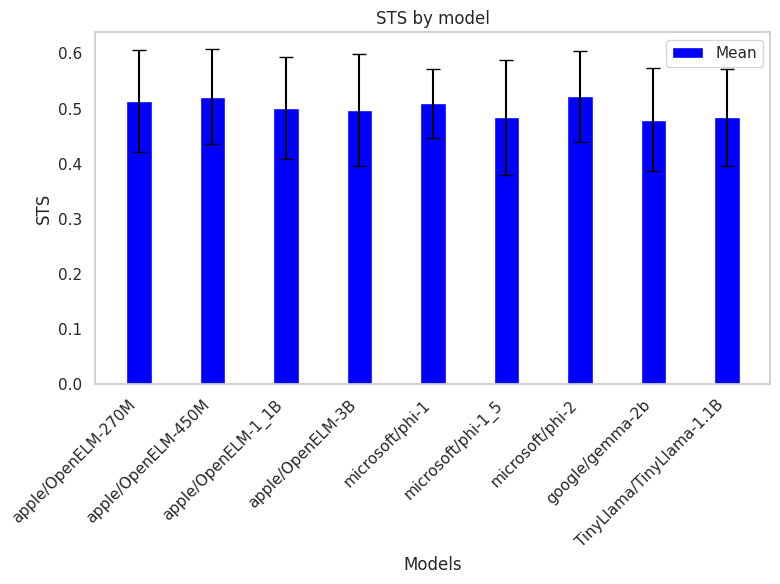

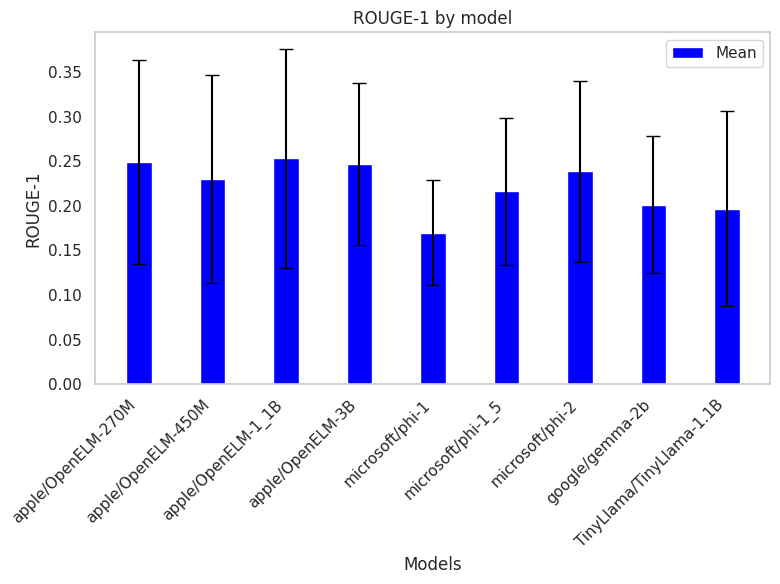

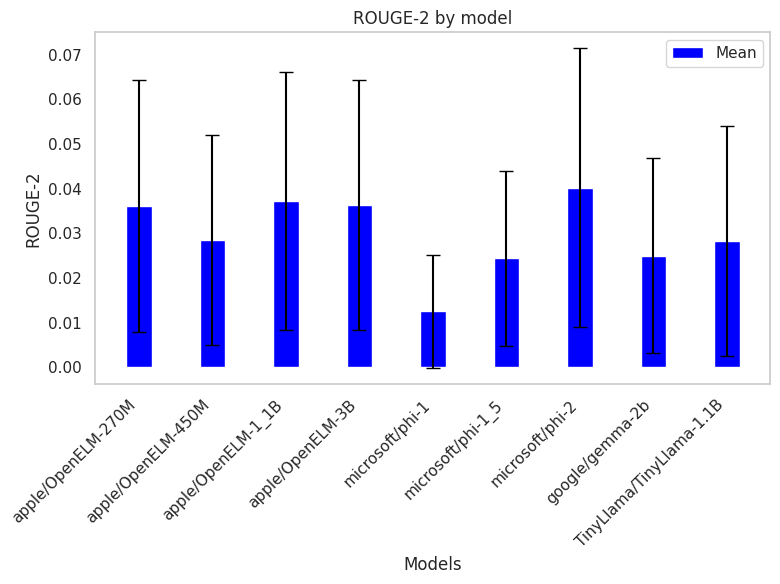

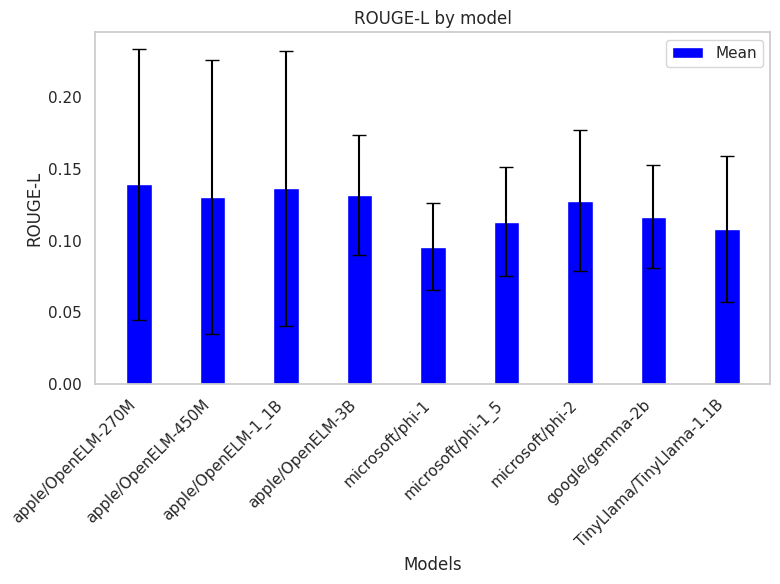

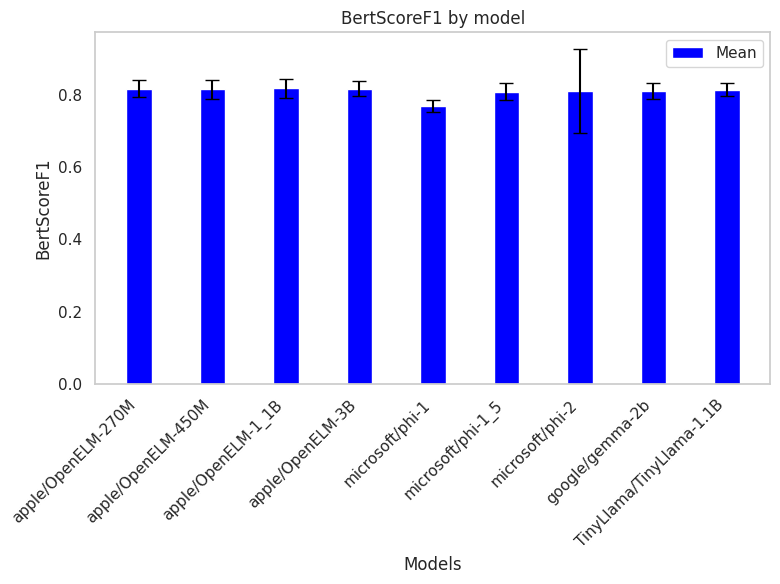

In [42]:
# Define function to plot
def plot_metrics(df, metric_mean, metric_std, metric_name):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    indices = np.arange(len(df['Model']))
    bar_width = 0.35
    
    # Plot bars for mean
    bars_mean = ax.bar(indices, df[metric_mean], bar_width, label='Mean', color='blue')
    
    # Add error bars for std
    ax.errorbar(indices, df[metric_mean], yerr=df[metric_std], fmt='none', ecolor='black', capsize=5)
    
    # Remove grid lines
    ax.grid(False)
    
    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by model')
    ax.set_xticks(indices)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend()
    
    fig.tight_layout()
    plt.show()

# Plot each metric
plot_metrics(df, 'STS_Mean', 'STS_Std', 'STS')
plot_metrics(df, 'ROUGE-1_Mean', 'ROUGE-1_Std', 'ROUGE-1')
plot_metrics(df, 'ROUGE-2_Mean', 'ROUGE-2_Std', 'ROUGE-2')
plot_metrics(df, 'ROUGE-L_Mean', 'ROUGE-L_Std', 'ROUGE-L')
plot_metrics(df, 'BertScoreF1_Mean', 'BertScoreF1_Std', 'BertScoreF1')

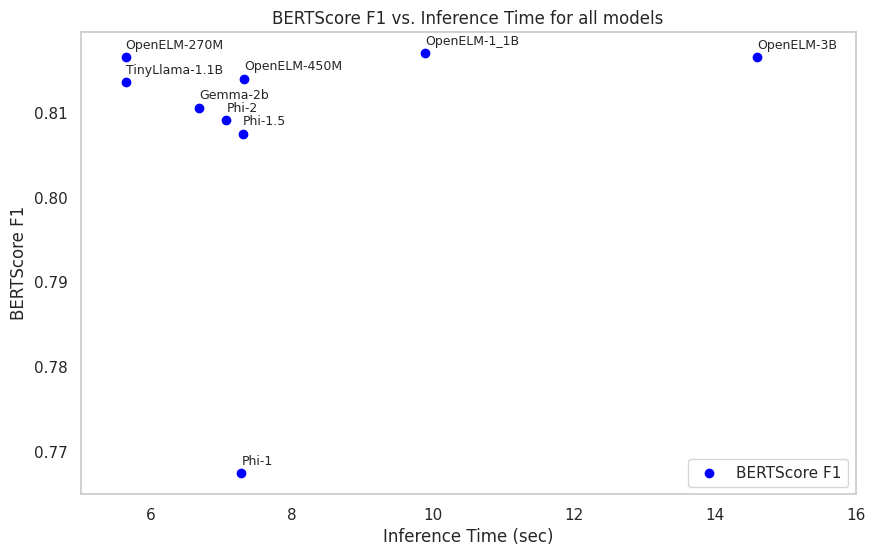

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Data in a dictionary format
data = {
    "Model": ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B", 
              "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2", "google/gemma-2b", 
              "TinyLlama/TinyLlama-1.1B"],
    "BertScoreF1_Mean": [0.8165, 0.8140, 0.8170, 0.8165, 0.7675, 0.8075, 0.8091, 0.8106, 0.8136]
}

# Inference time data from the table
inference_data = {
    "Model": ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B", 
              "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2", "google/gemma-2b", 
              "TinyLlama/TinyLlama-1.1B"],
    "Inference_Time": [5.64, 7.32, 9.89, 14.60, 7.28, 7.30, 7.07, 6.68, 5.65]
}

# Create a DataFrame for both datasets
df_bert = pd.DataFrame(data)
df_inference = pd.DataFrame(inference_data)

# Merge the DataFrames on the 'Model' column
df_combined = pd.merge(df_bert, df_inference, on='Model')

# Plot BERTScore vs. Inference Time
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df_combined['Inference_Time'], df_combined['BertScoreF1_Mean'], label='BERTScore F1', color='blue')

# Add labels and title
ax.set_xlabel('Inference Time (sec)')
ax.set_ylabel('BERTScore F1')
ax.set_title('BERTScore F1 vs. Inference Time for all models')

# Add numbers as annotations with a slight offset
names = ["OpenELM-270M", "OpenELM-450M", "OpenELM-1_1B", "OpenELM-3B", "Phi-1", "Phi-1.5", "Phi-2", "Gemma-2b","TinyLlama-1.1B"]
# for i in range(len(df_combined)):
#     ax.annotate(str(i + 1), (df_combined['Inference_Time'][i] , df_combined['BertScoreF1_Mean'][i] + 0.001), fontsize=9, ha='left')

for i in range(len(df_combined)):
    ax.annotate(names[i], (df_combined['Inference_Time'][i] , df_combined['BertScoreF1_Mean'][i] + 0.001), fontsize=9, ha='left')

plt.xlim([5,16])
plt.legend()
plt.grid(False)
plt.show()


In [68]:
 # load the csv file which contain questions and answers pairs 
QA_df = pd.read_csv("result_file.csv")

# Convert the 'output' column to string type
QA_df['output'] = QA_df['output'].astype(str)


# Find the  average output token length 
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

token_length = 0

for i in QA_df['output']:
    tokens = tokenizer.tokenize(i)
    token_length +=  len(tokens)

avg_token_length = token_length / len(QA_df)

print(f"Average token length: {avg_token_length}")


/home/trkosire/LLM_RESEARCH/Finance/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Average token length: 252.26732673267327


In [76]:

pd.set_option('display.max_colwidth', None)  # Show full column text
pd.set_option('display.max_rows', None) 



In [78]:
QA_df.columns

Index(['total_input', 'output', 'apple/OpenELM-270M_reponse',
       'apple/OpenELM-450M_reponse', 'apple/OpenELM-1_1B_reponse',
       'apple/OpenELM-3B_reponse', 'microsoft/phi-2_reponse',
       'google/gemma-2b_reponse', 'microsoft/phi-1_reponse',
       'TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T_reponse',
       'microsoft/phi-1_5_reponse'],
      dtype='object')

In [84]:
QA_df.iloc[70]

total_input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T_reponse               


In [85]:
QA_df

,total_input,output,apple/OpenELM-270M_reponse,apple/OpenELM-450M_reponse,apple/OpenELM-1_1B_reponse,apple/OpenELM-3B_reponse,microsoft/phi-2_reponse,google/gemma-2b_reponse,microsoft/phi-1_reponse,TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T_reponse,microsoft/phi-1_5_reponse
0,"Utilize your financial knowledge, give your answer or opinion to the input question or subject . Answer format is not limited.\nWhat can I do with â€œstaleâ€ checks? Can I deposit/cash them?","Check is an obligation to pay, and is unconditional. In the US, checks don't expire (there are countries where they do). Endorsements such as ""void after X days"" are meaningless and don't affect the obligation to pay. The bank is under no obligation to honor a check that is more than 6 months old (based on the date on the check, of course). This is from the Unified Commercial Code 4-404. However, this refers to the bank, not to the person who gave you the check. The bank may pay, if the check is deposited in good faith and there's nothing wrong with it or with the account. So the first thing you can do is deposit the check. If asked - you can say that the person just wrote the wrong date, which is true. Worst case the check bounces. If the check bounces - you can start with demand letters and small claim courts. The obligation to pay doesn't go away unless satisfied, i.e.: paid.","How do I deposit/ cash them? How much does it cost to deposit or cash checks? Can I use my bank account to deposit checks? What is the difference between cashing a check and depositing it? Can I use cash in my bank account to cash a check? How do I cash checks?\nWhen you receive a check from someone who is not a bank, can you deposit it? How do you cash a check at the bank? How do I get a check deposited into my account?\nWhat is the difference between a deposit and cash deposit? How do I put money into my checking account? How do I transfer money from my checking account to my savings account? What is the best way to deposit money from my checking to my savings?\nI don't have a checking account but I'm planning to open a checking account. I want to know if there are any charges involved? Can I put money into an account for a deposit? How can I withdraw money from my checking or savings account?\nHow do I get a cashier's check? How can I get a cashed check? How","\nYes. If you deposit/cashed a check, you can put it in your account. The account is used to pay your bills.\nYou can deposit or cash stale checks, but you can not cash them in.\nYes. The first step in the account opening process is to make a deposit.\nCan I transfer funds from my checking account to my savings account?\nNo. There is a limit on how much money you can transfer from checking to savings accounts. If you have a savings account that is at least $1,000, you can transfer funds from your checking account to your savings account.\nWhat is the difference between a savings account and a checking account?\nSavings accounts are an account that does not have a daily limit. You can deposit as much money as you want into your account without worrying about the money you deposit going into your account.\nYou can have both types of accounts. If you want to deposit and then have the money in your savings account, then you must open a savings account. If you want the money in your checking account, then you should open a checking account.\n","\nYes, but not without a fee.\nYou can deposit them into your bank account (free), but be aware that your bank may charge a fee to do so.\nIn many cases, it is better to keep the check for identification purposes.\nIf you have a large number of stale checks, you may want to consider using a bank check cashing service.\nCheck cashing fees may vary by location.\nWhat if I have more than one stale check?\nYou can use the same stale check more than once, but be aware that there is a limit to the number of stale/expired checks that can be deposited into your bank account each month.\nChe

In [87]:
df_10 = pd.read_csv("new_file_10.csv")


0                                                            \nIn this section, we will explore the concept of mortgages and how they can be viewed as an investment. We will also discuss the benefits of paying down a mortgage early and the factors that contribute to this decision. By the end of this section, you will have a better understanding of how mortgages can be viewed as a long-term investment and the potential advantages of paying them off sooner rather than later.\n\nWhat are mortgages and why do people have them?\n\nMortgages are loans that individuals or families take out to purchase a property. They are typically used to buy a house, an apartment, or other types of real estate. Mortgages allow people to become homeowners without having to pay the full purchase price upfront. Instead, they borrow money from a bank or lender and make monthly payments to repay the loan over time.\n\nPeople take out mortgages for various reasons. Some may want to build equity in their homes by 

In [89]:
print(df_10['microsoft/phi-1_reponse'])


0                               \n\n\nfrom typing import List\n\ndef most_balanced_word_pairs(words: List[str]) -> List[str]:\n    """\n    Returns a list of the most balanced word pairs in the input list of words.\n    A word pair is considered balanced if the absolute difference between the lengths of the two words in the pair\n    is minimized. If there are multiple balanced word pairs with the same minimum absolute difference, all of them\n    are returned in the output list.\n    \n    Args:\n    - words: a list of strings representing words\n    \n    Returns:\n    - a list of strings, where each string is a pair of words that are the most balanced in the input list\n    \n    Example:\n    >>> most_balanced_words_pairs(['cat', 'dog', 'bat', 'rat', 'cow'])\n    ['cat-bat', 'dog-rat']\n    """\n        \n    # Initialize variables to keep track of the most balanced pairs\n    min_diff = float('inf')\n    balanced_pairs = []\n    \n    # Iterate through all pairs of words in the
1 